## Continuous Sapientino.

Level of abstraction "two", with restraining bolts.

The goal is to visit N colors in a certain order.

We use a modular network architecture: that is, for each state of
the goal automaton, we activate the $q^{th}$ subnetwork.

In [18]:
import tempfile
import time
from pathlib import Path

import gym
import numpy as np
from flloat.semantics import PLInterpretation
from gym.wrappers import TimeLimit
from stable_baselines import DQN

from gym_sapientino import SapientinoDictSpace
from gym_sapientino.core.configurations import (
    SapientinoAgentConfiguration,
    SapientinoConfiguration,
)
from multinav.algorithms.modular_dqn import ModularPolicy
from multinav.envs.env_grid_sapientino import generate_grid
from multinav.helpers.gym import rollout
from multinav.helpers.notebooks import plot_env, display_img_array, print_env
from multinav.restraining_bolts.automata import make_sapientino_goal_with_automata
from multinav.restraining_bolts.rb_grid_sapientino import GridSapientinoRB
from multinav.wrappers.sapientino import ContinuousRobotFeatures
from multinav.wrappers.temprl import MyTemporalGoalWrapper
from multinav.wrappers.utils import MyStatsRecorder, SingleAgentWrapper

In [19]:
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Observation space: Box(0.0, 5.0, (3,), float32)


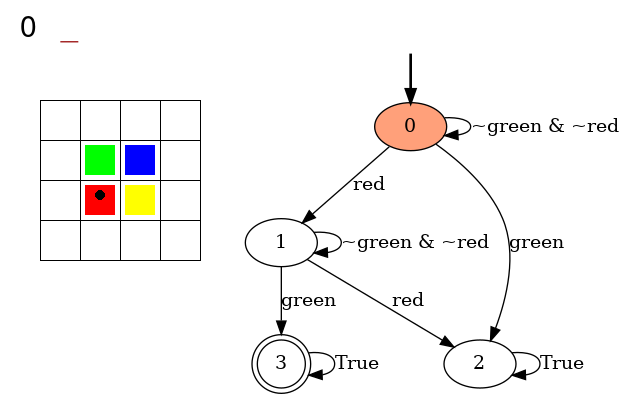

In [20]:
SQUARE_MAP = """\
    |
 gb |
 ry |
    |"""

COLORS = ["red", "green"] #, "yellow", "blue"]

def extract_sapientino_fluents(obs, action) -> PLInterpretation:
    """Extract Sapientino fluents."""
    is_beep = obs.get("beep") > 0
    color_id = obs.get("color")
    if is_beep and 0 <= color_id - 1 < len(COLORS):
        color = COLORS[color_id - 1]
        fluents = {color} if color in COLORS else set()
    else:
        fluents = set()
    return PLInterpretation(fluents)

agent_configuration = SapientinoAgentConfiguration(continuous=False, initial_position=(1, 2))
temp_file = Path(tempfile.mktemp(suffix=".txt"))
temp_file.write_text(SQUARE_MAP)
configuration = SapientinoConfiguration(
    (agent_configuration, ),
    path_to_map=temp_file,
    reward_per_step=-0.01,
    reward_outside_grid=-1.0,
    reward_duplicate_beep=0.0,
)
env = SingleAgentWrapper(SapientinoDictSpace(configuration))
tg = make_sapientino_goal_with_automata(COLORS, extract_sapientino_fluents, reward=1.0)
env = ContinuousRobotFeatures(MyTemporalGoalWrapper(env, [tg]))

print(f"Observation space: {env.observation_space}")
display_img_array(env.render(mode="rgb_array"))

In [7]:
%tensorboard --logdir logs

In [21]:
learn_env = MyStatsRecorder(TimeLimit(env, max_episode_steps=30))

model = DQN(ModularPolicy, learn_env, verbose=1, tensorboard_log="./logs",
            learning_starts=5000, exploration_final_eps=0.1, policy_kwargs=dict(layers=[64, 64]))
model.learn(total_timesteps=50000)

--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 100      |
| mean 100 episode reward | -12.6    |
| steps                   | 2945     |
--------------------------------------


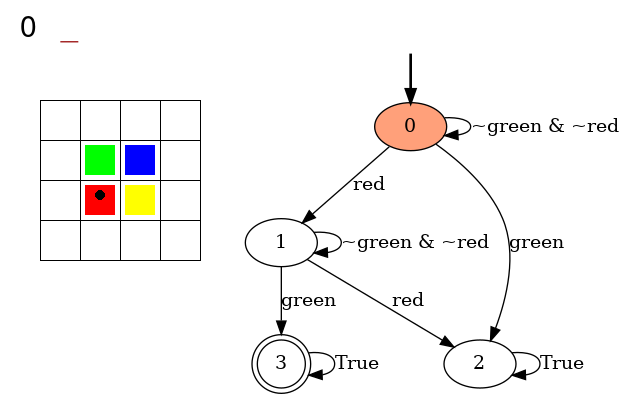

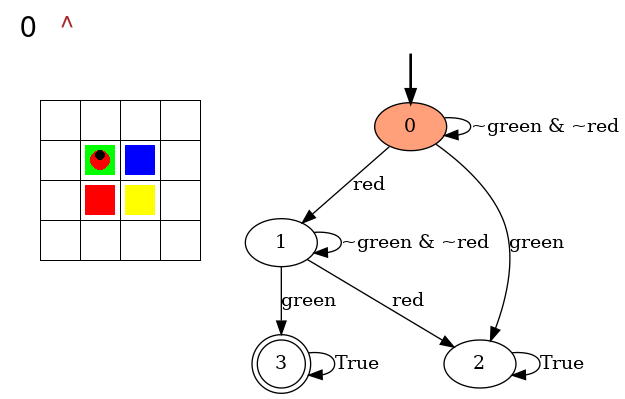

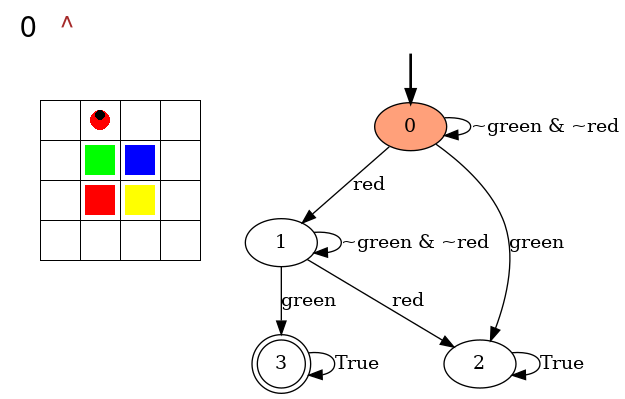

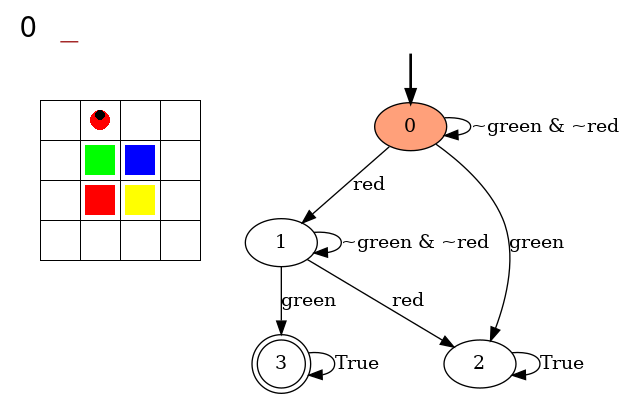

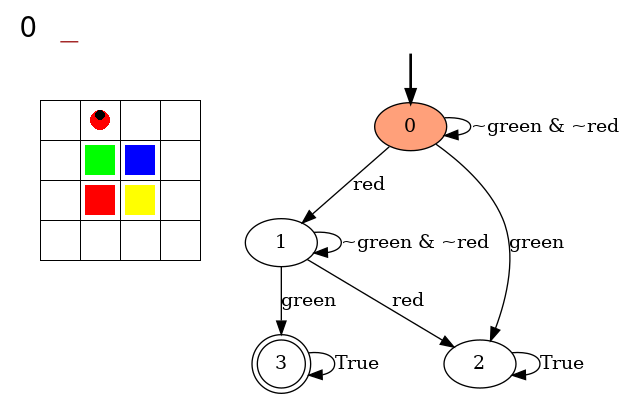

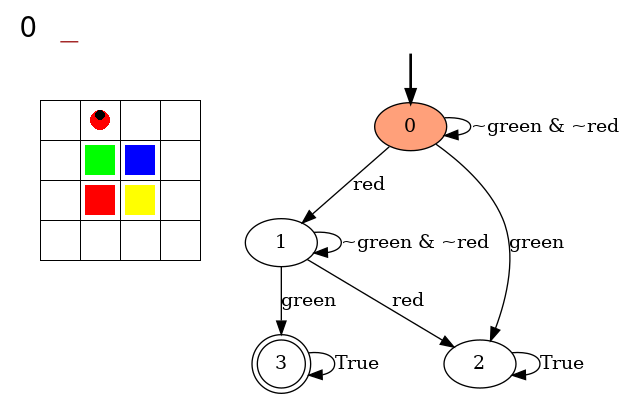

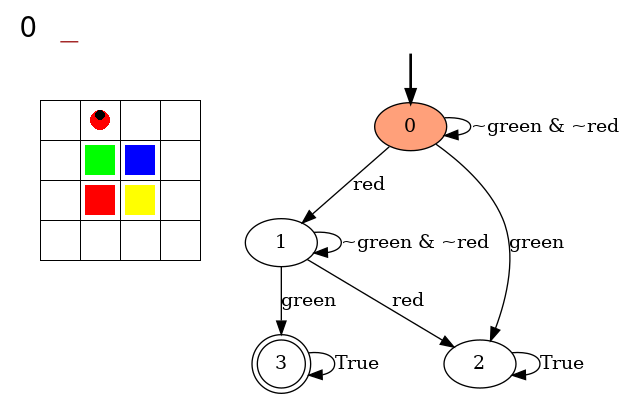

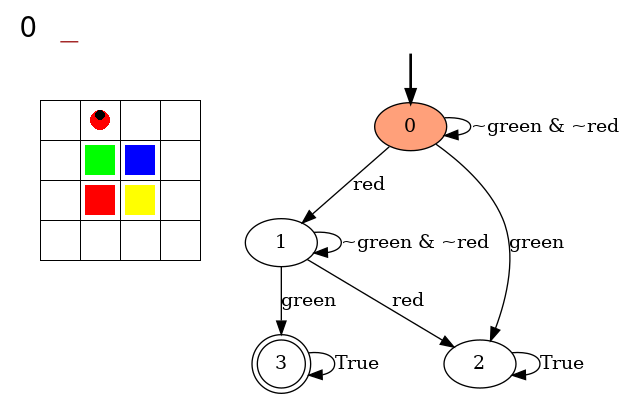

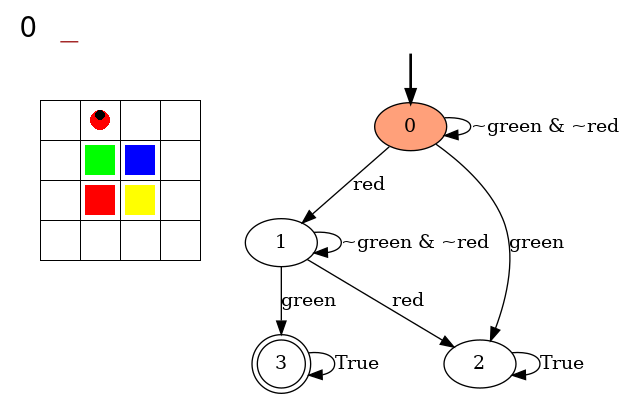

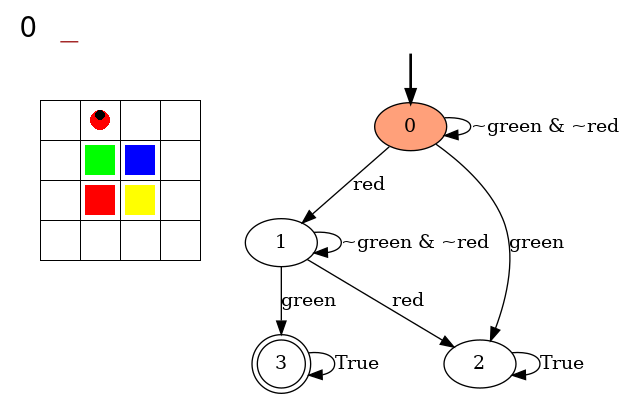

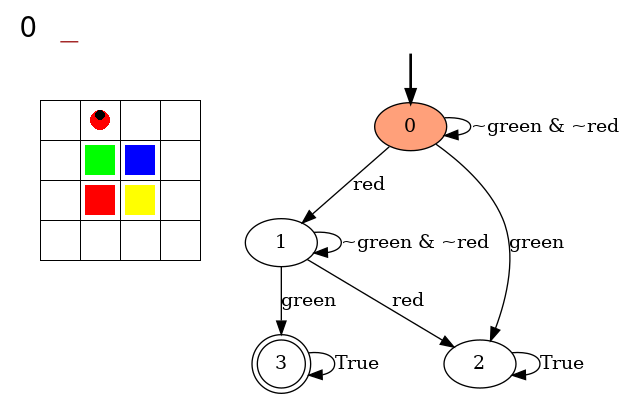

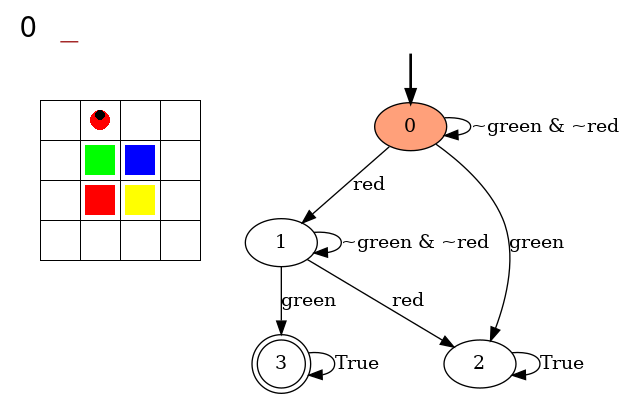

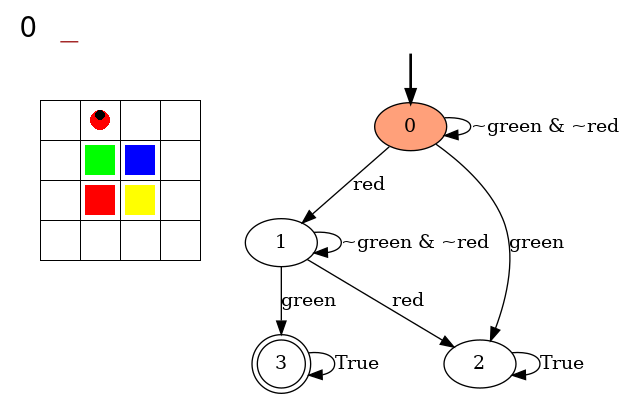

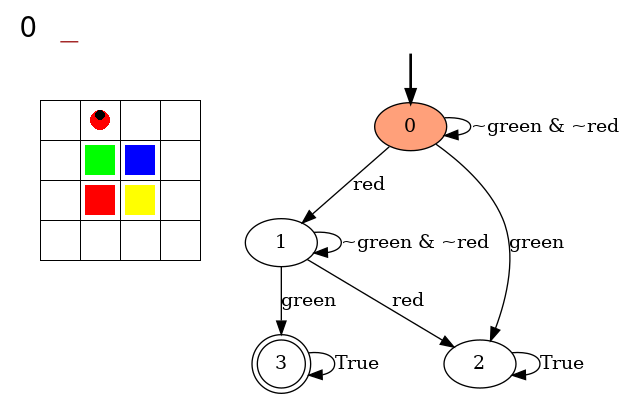

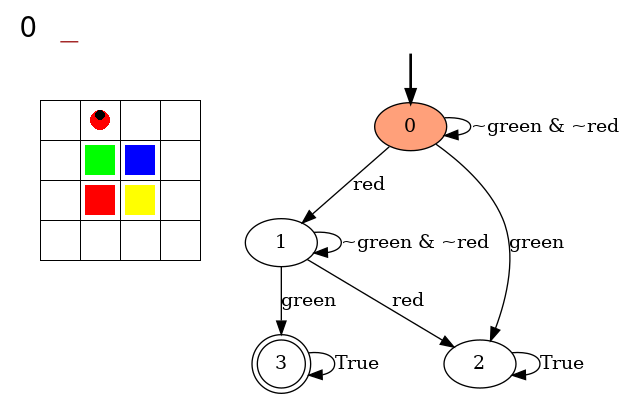

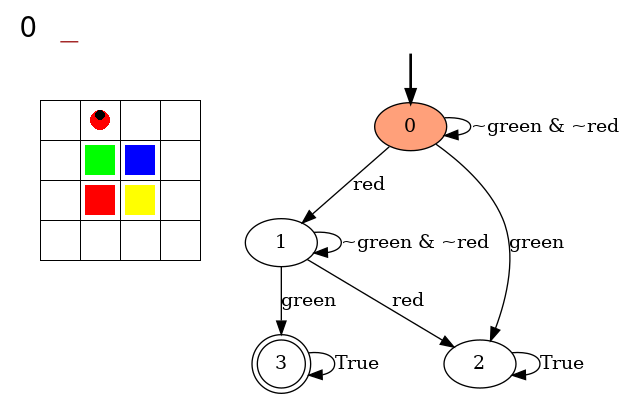

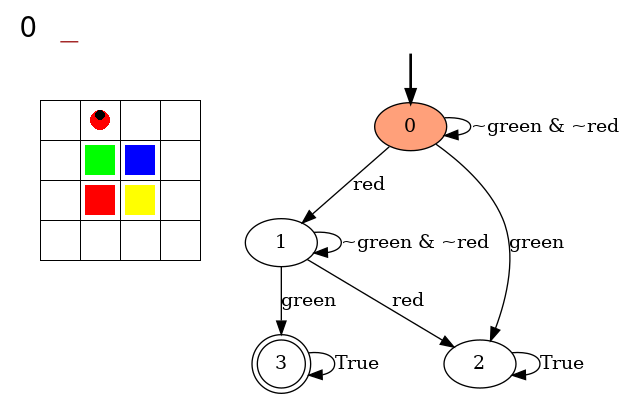

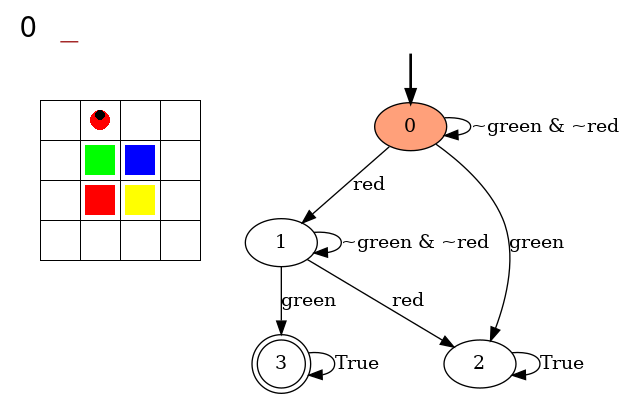

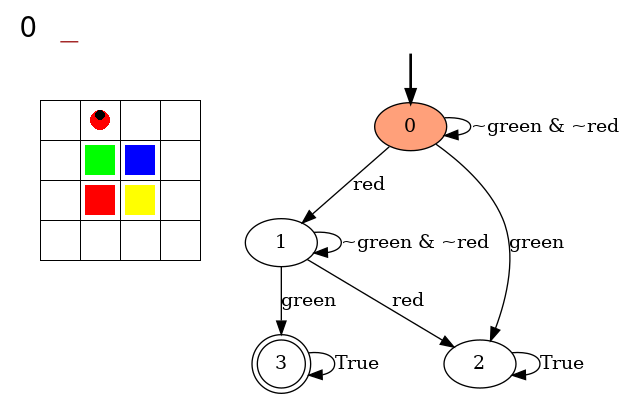

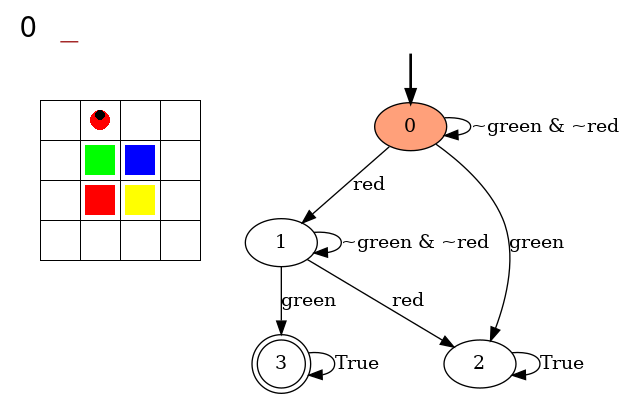

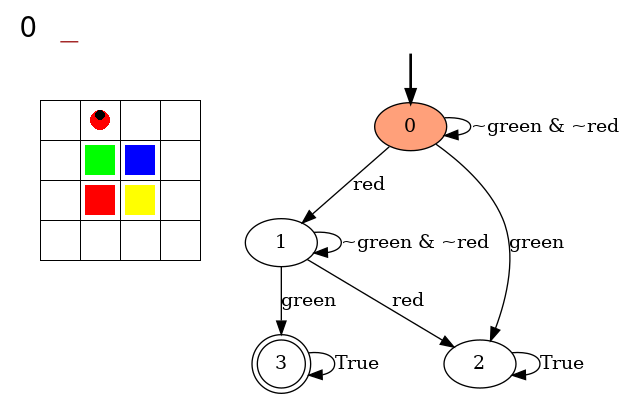

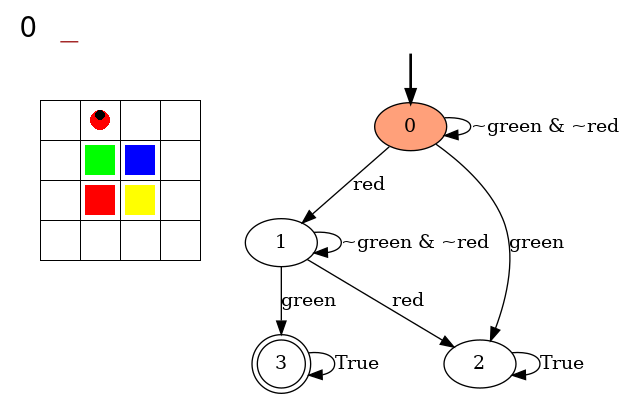

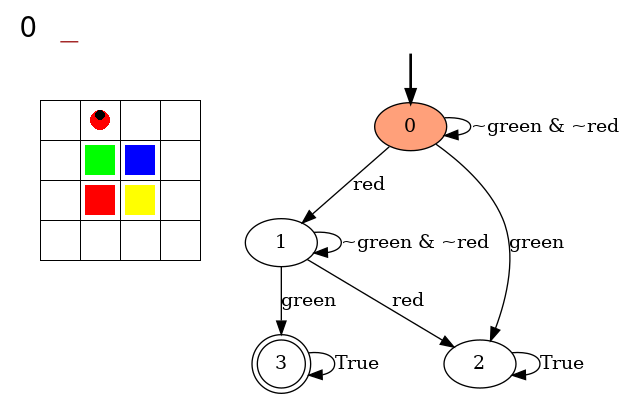

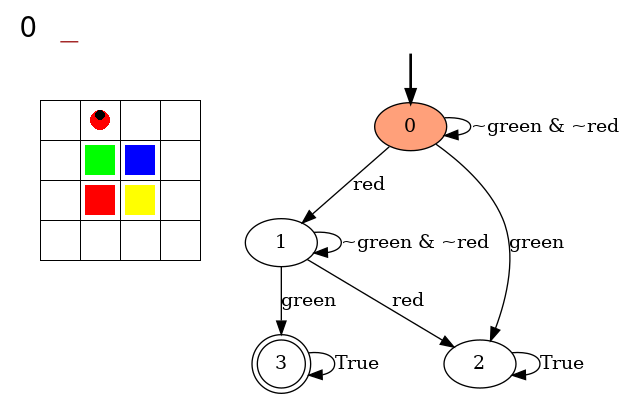

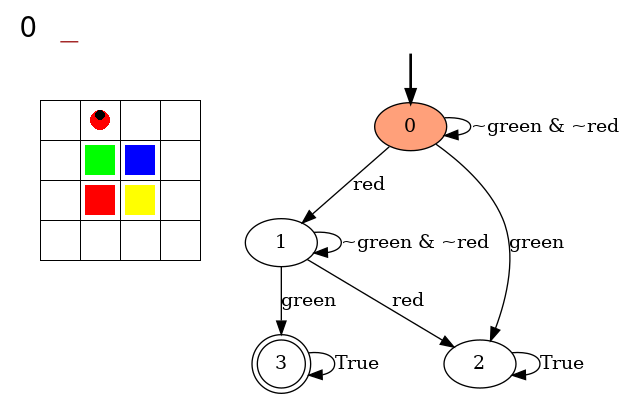

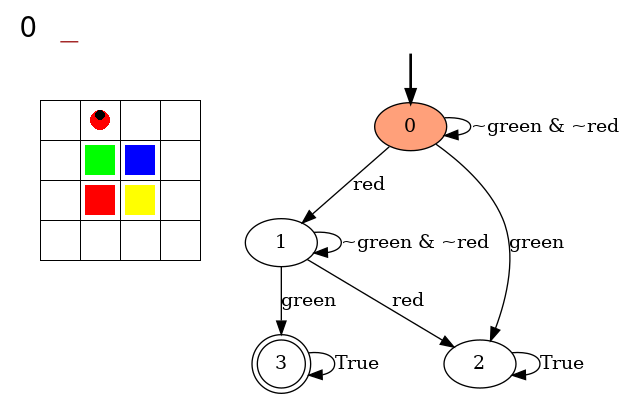

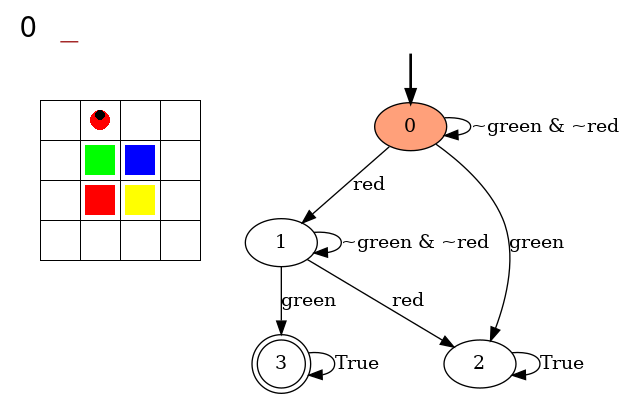

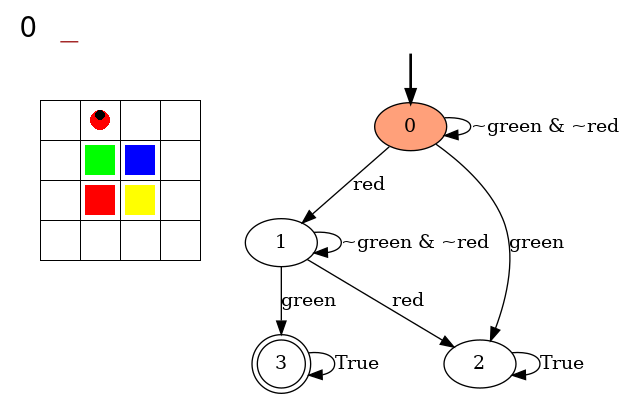

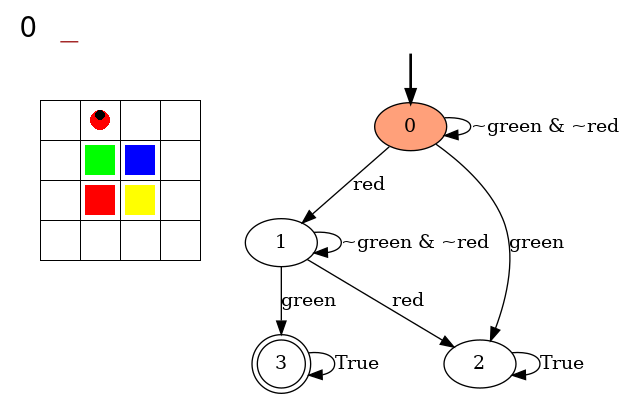

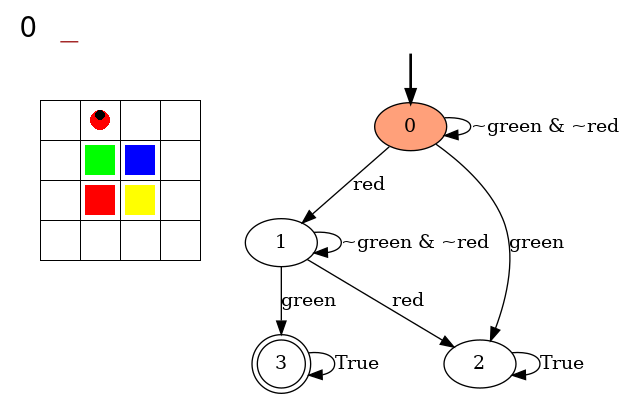

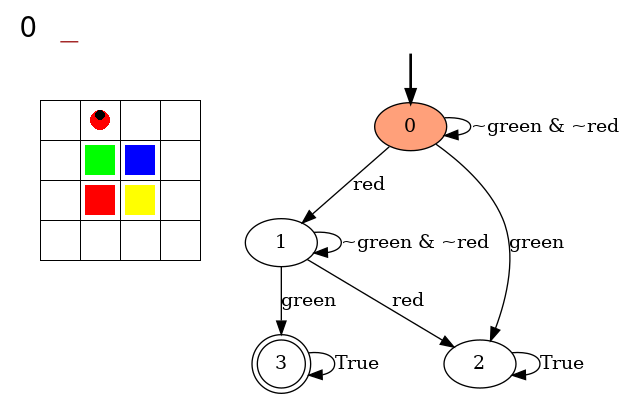

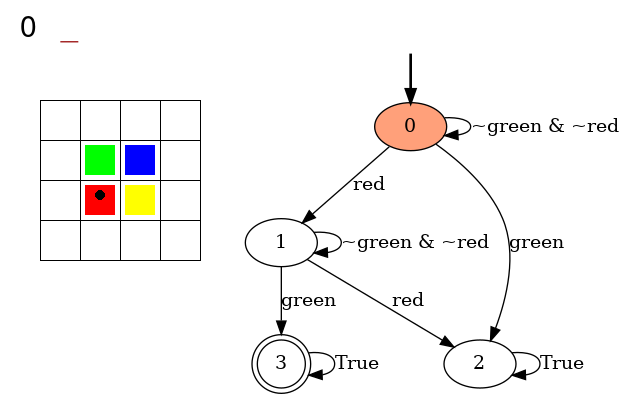

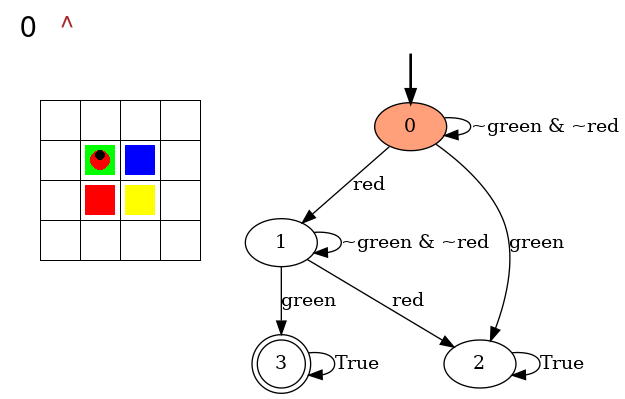

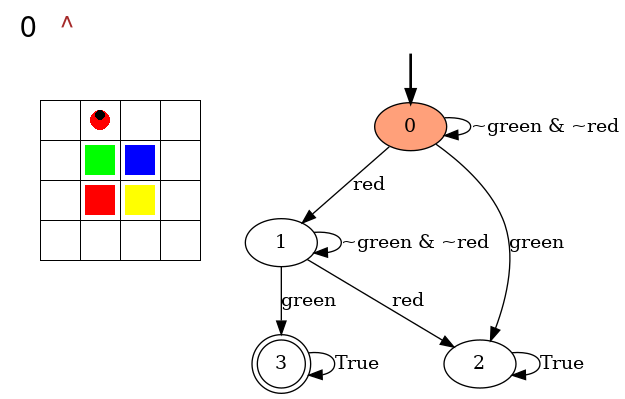

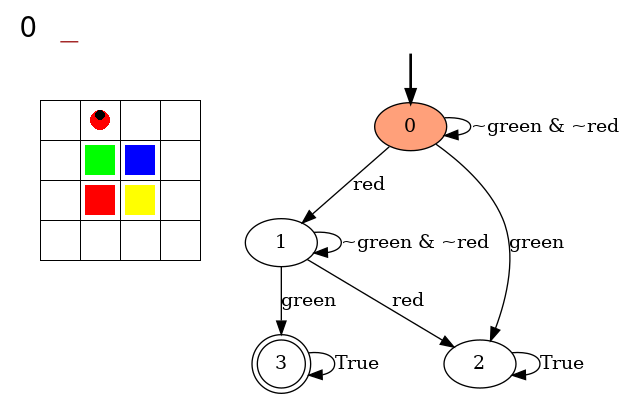

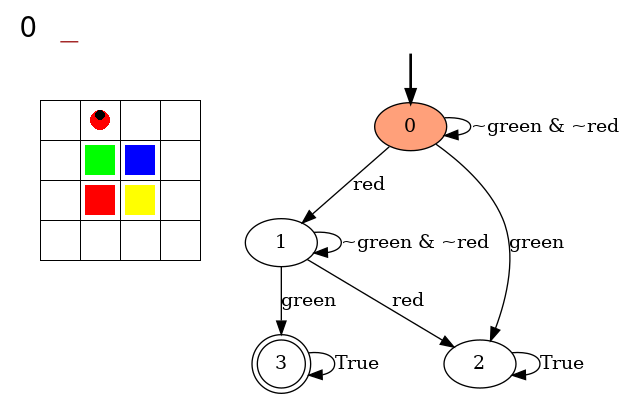

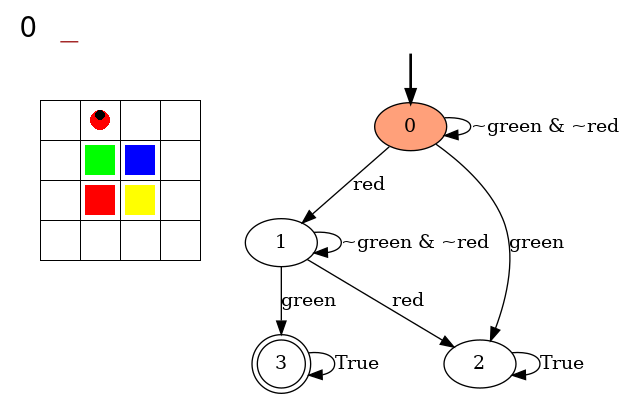

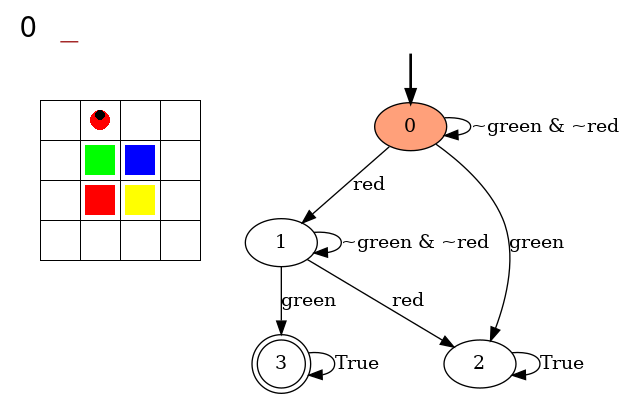

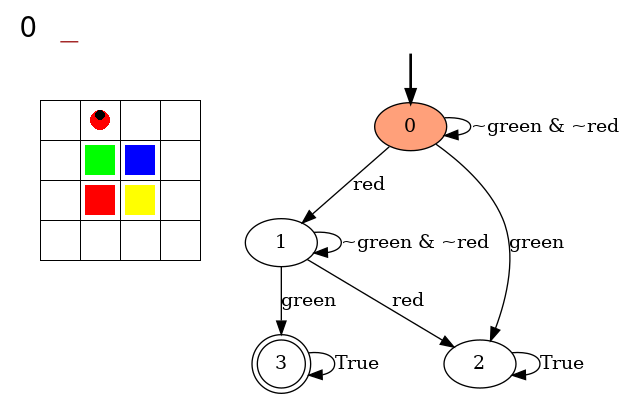

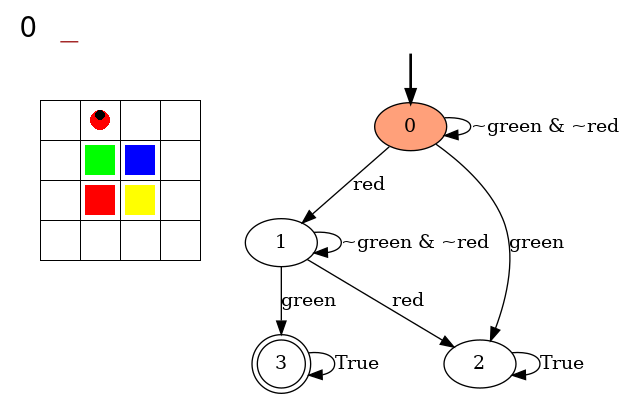

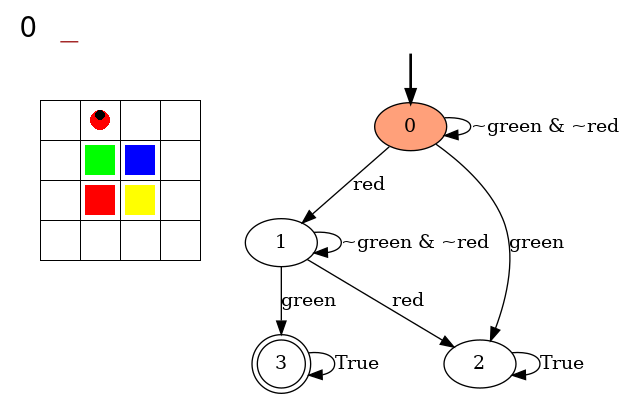

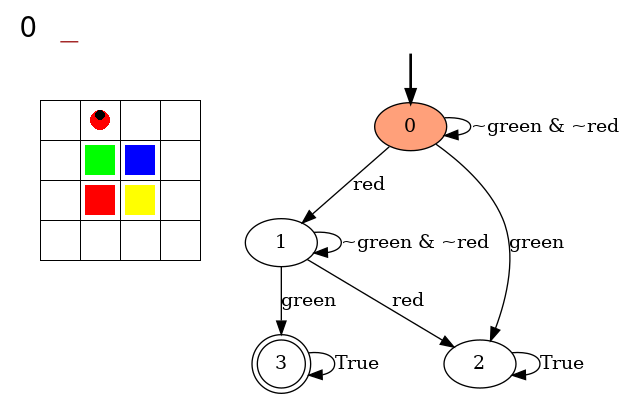

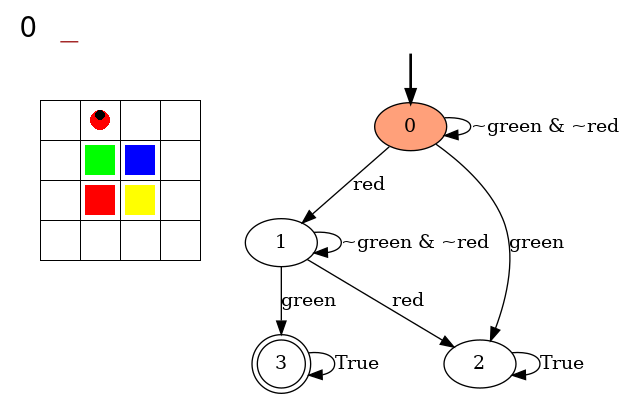

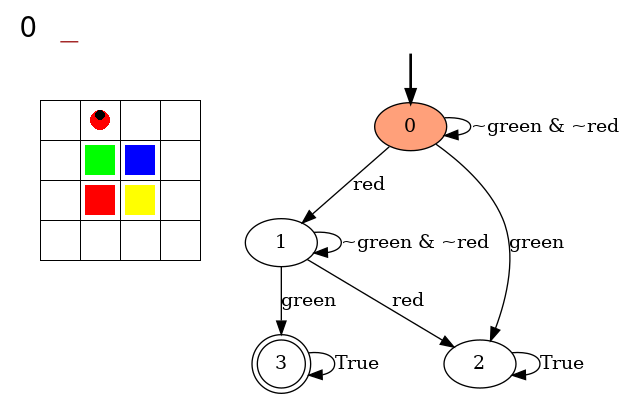

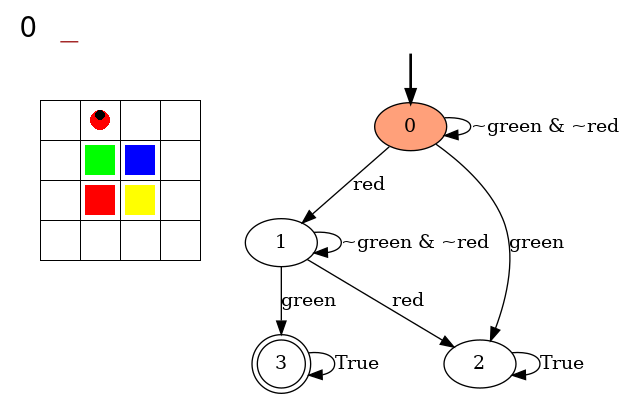

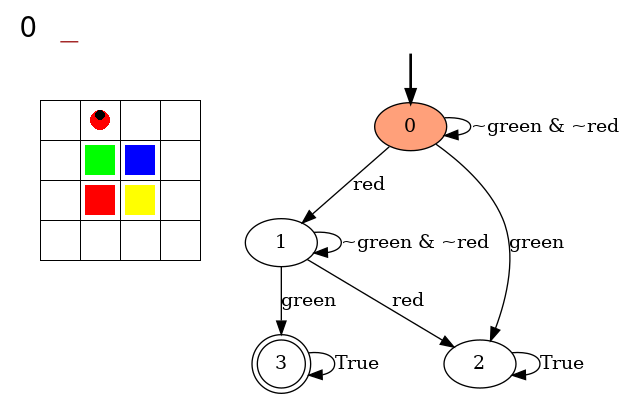

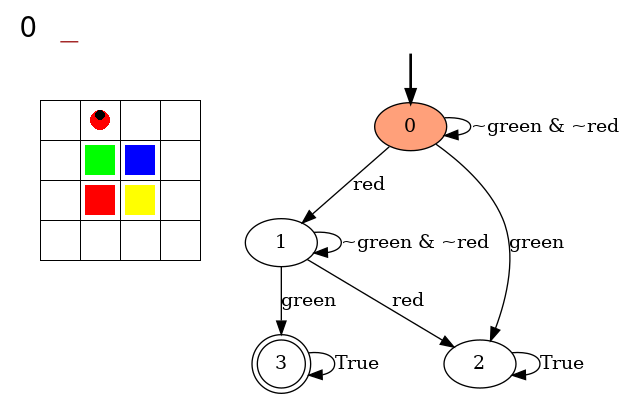

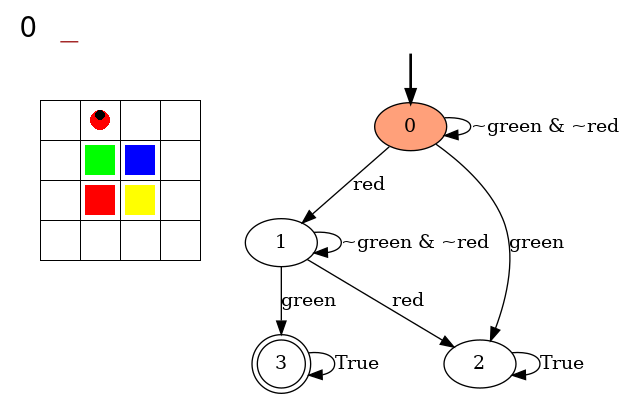

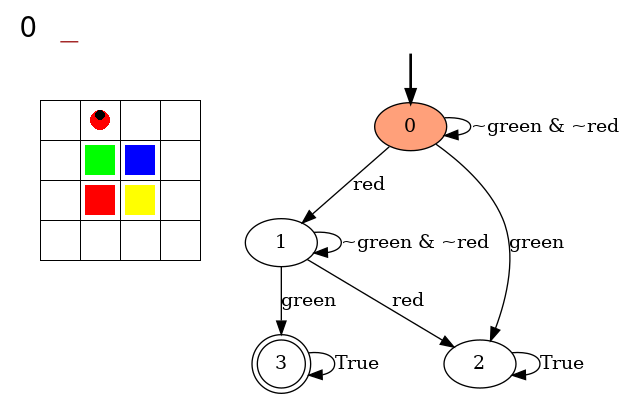

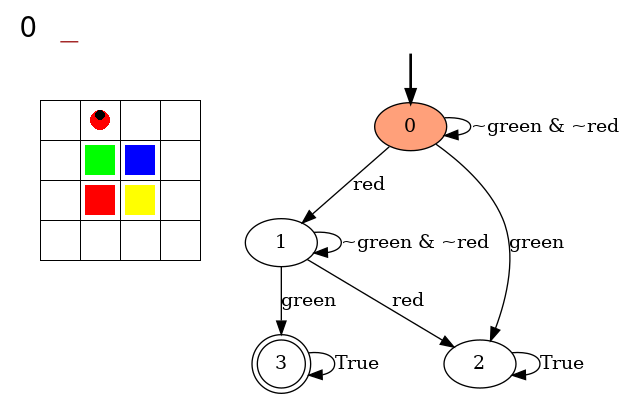

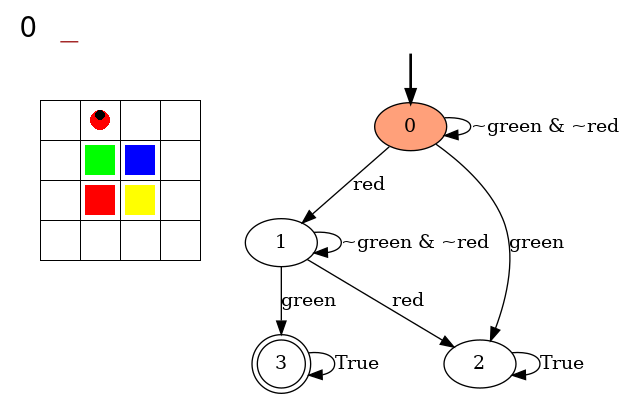

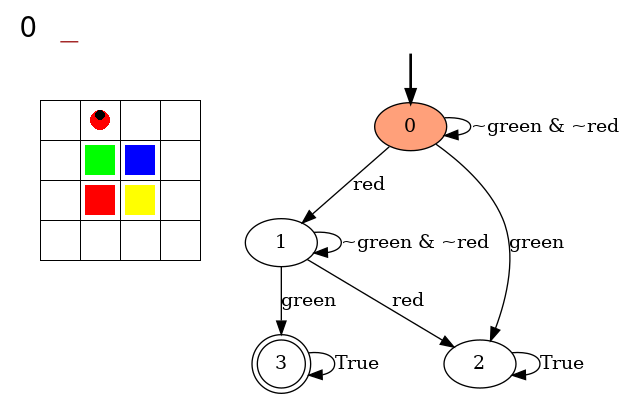

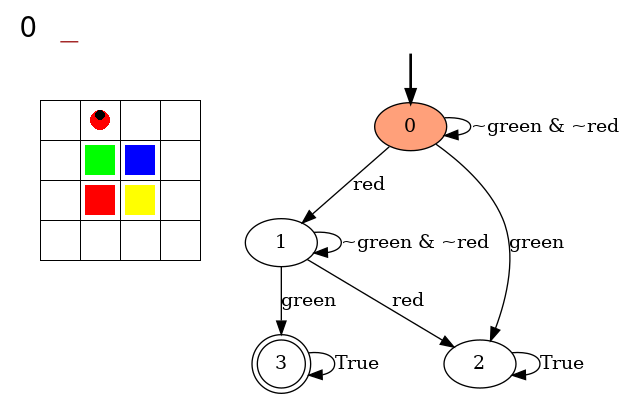

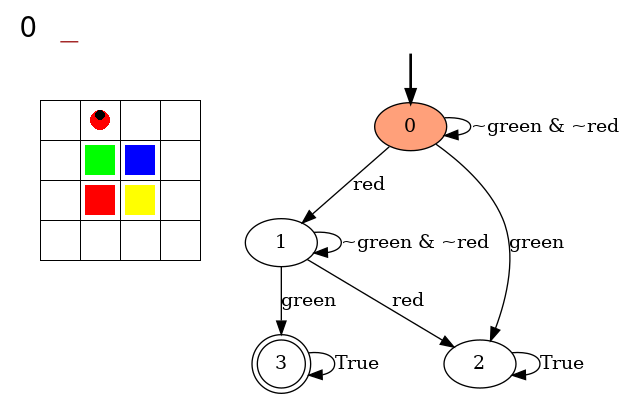

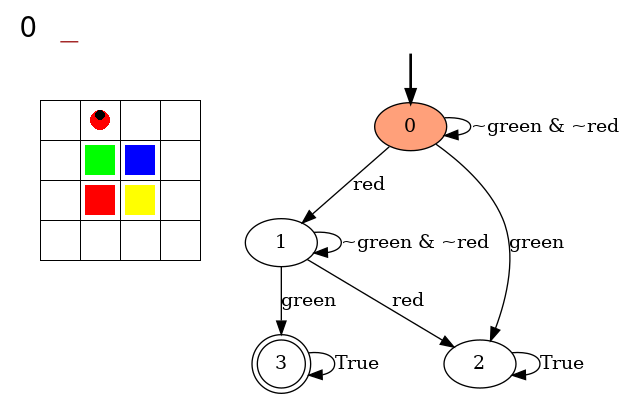

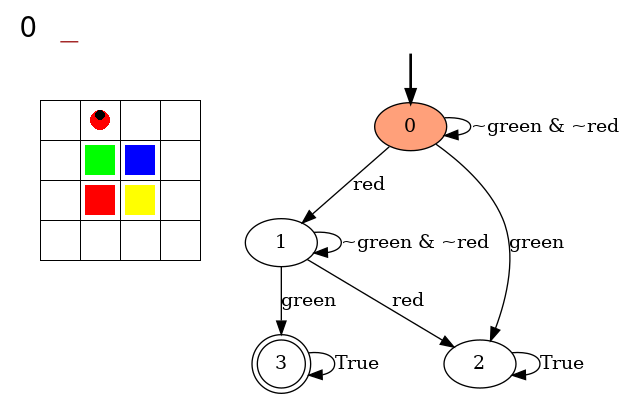

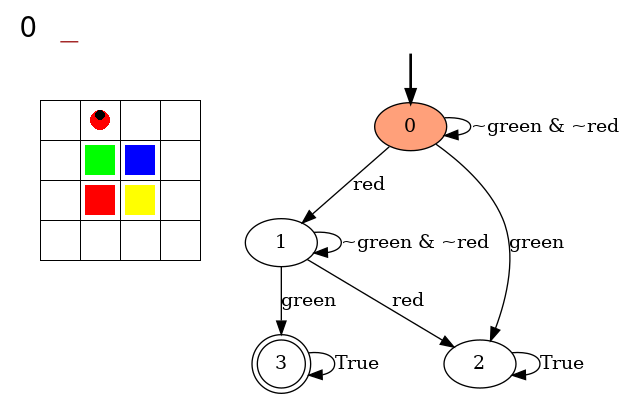

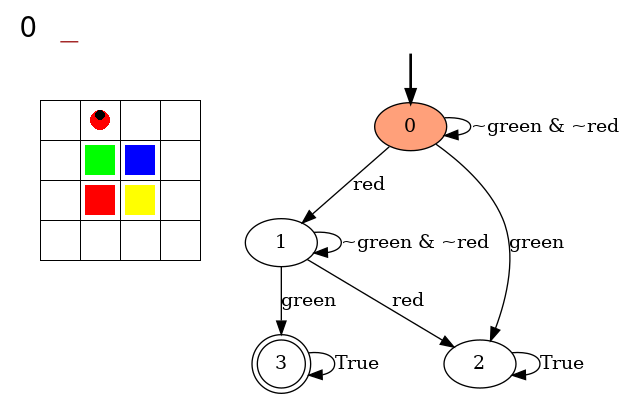

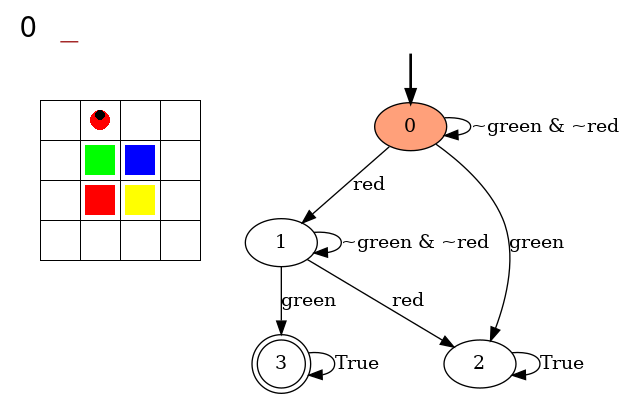

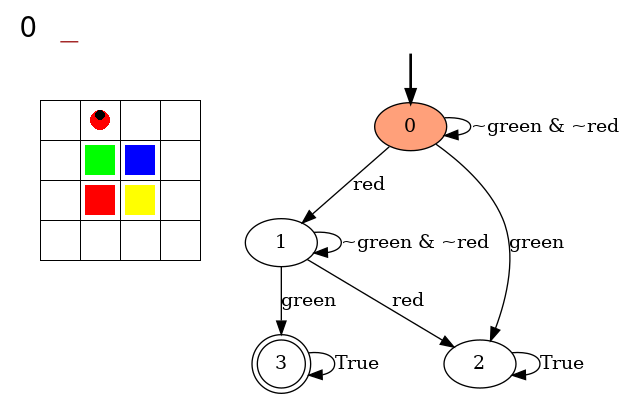

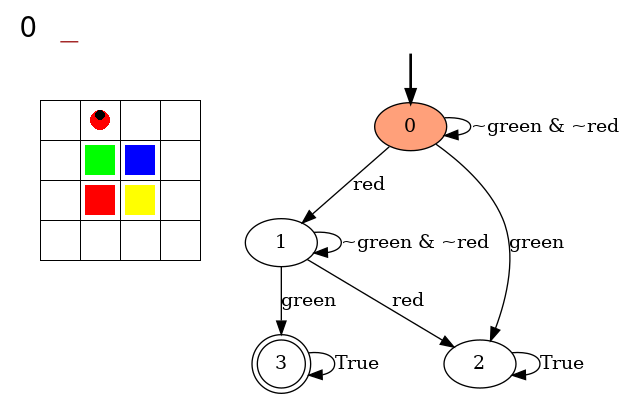

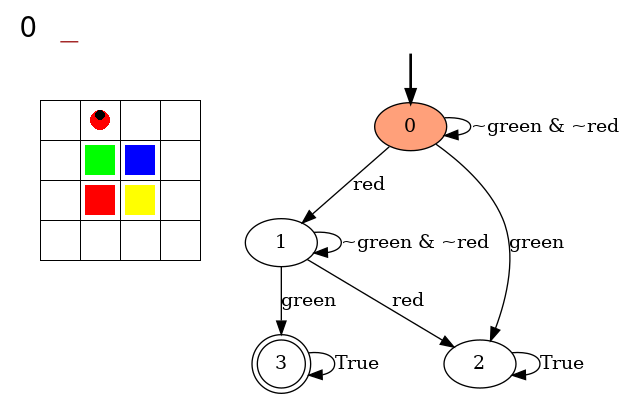

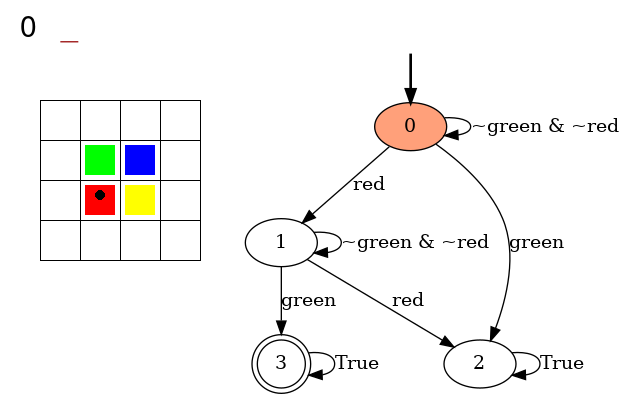

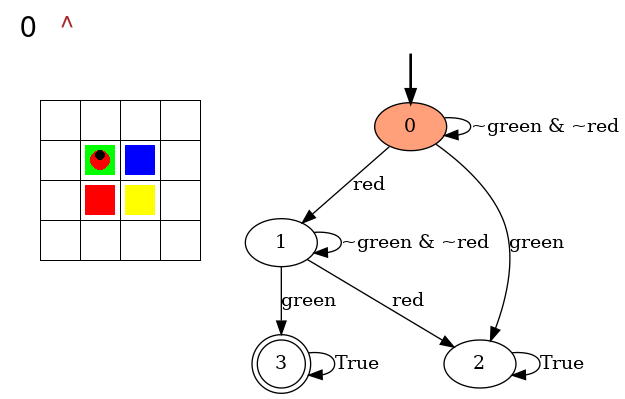

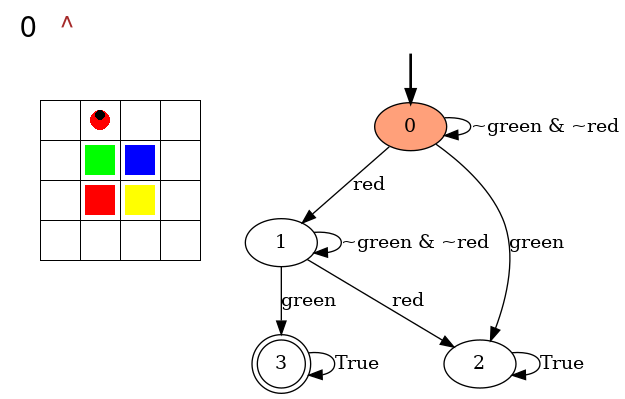

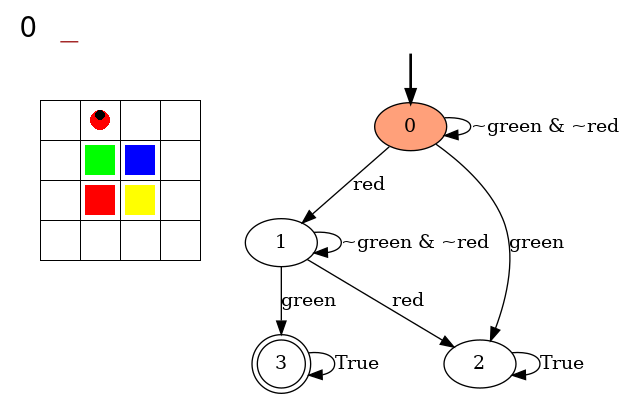

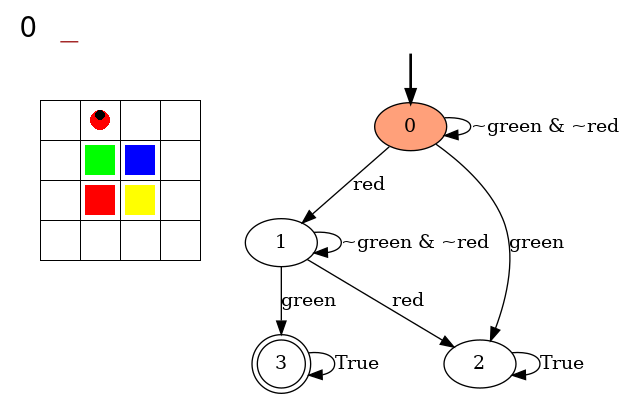

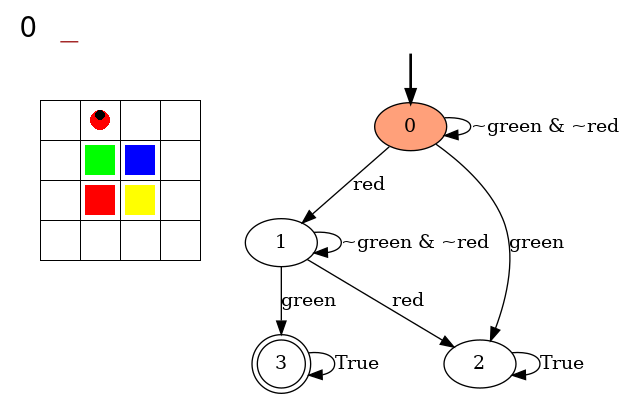

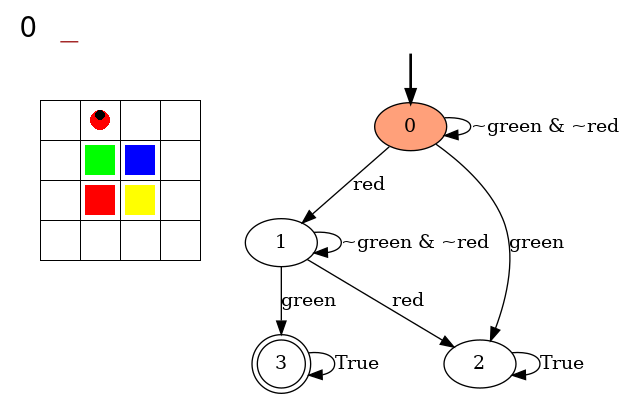

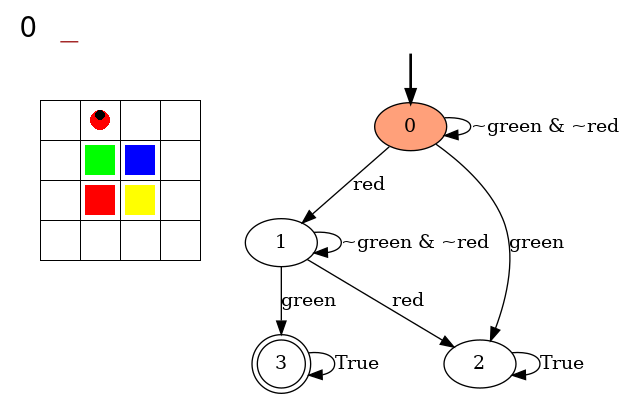

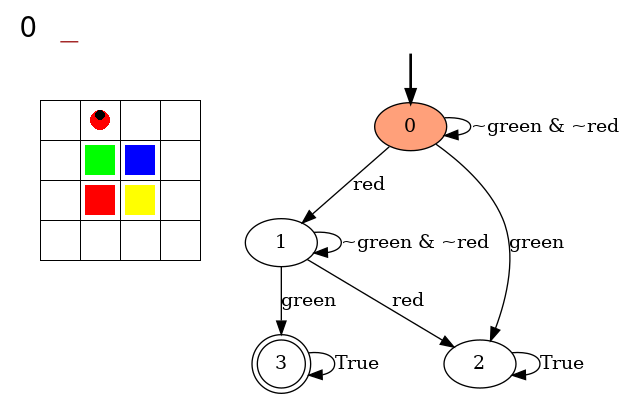

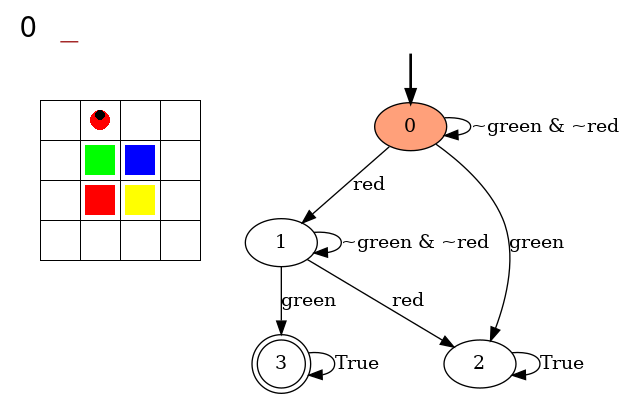

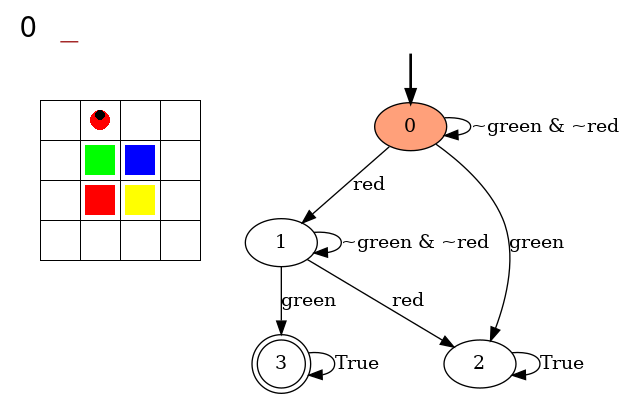

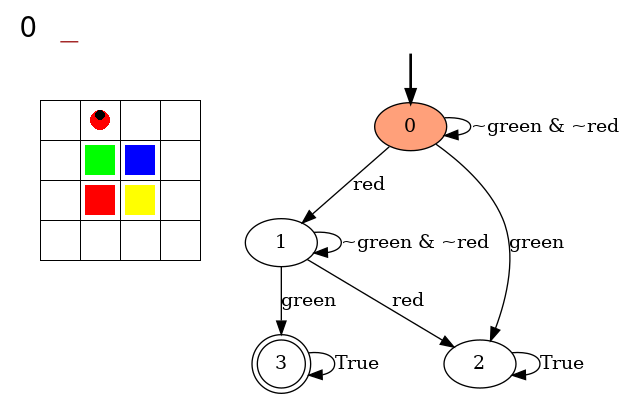

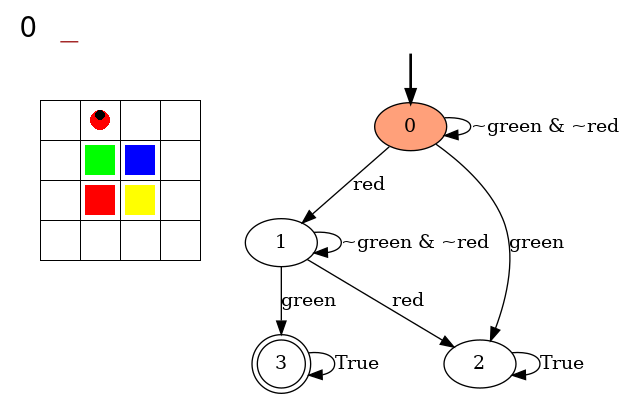

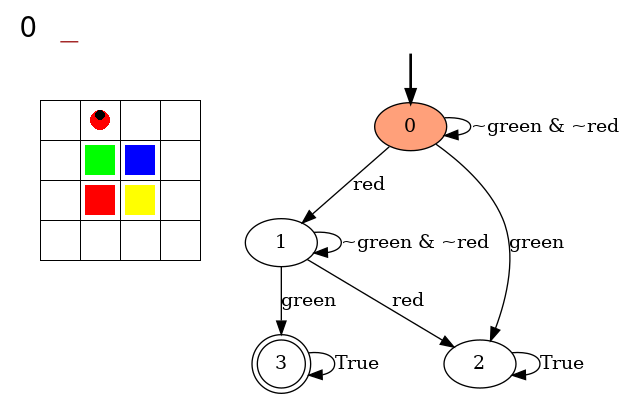

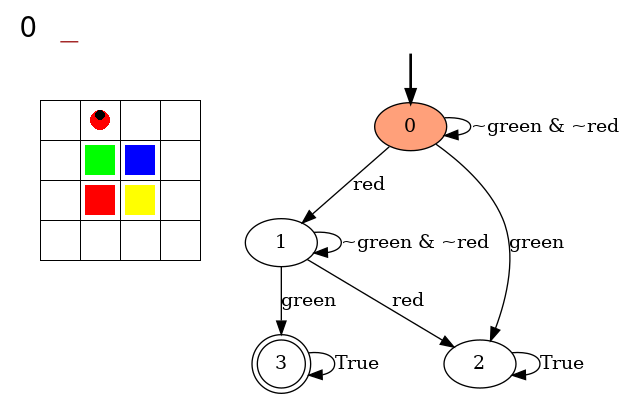

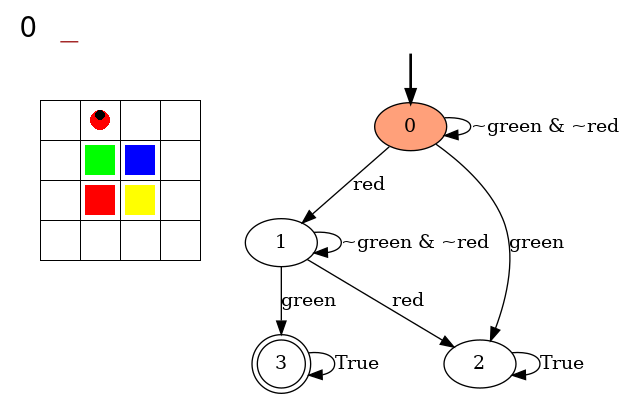

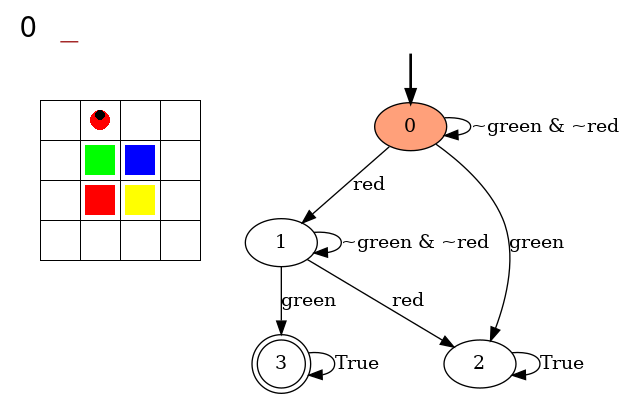

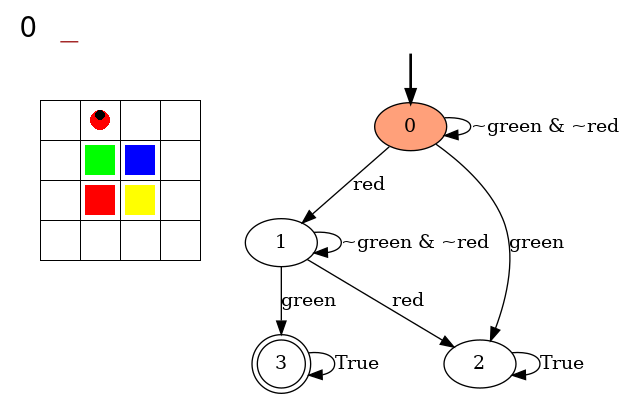

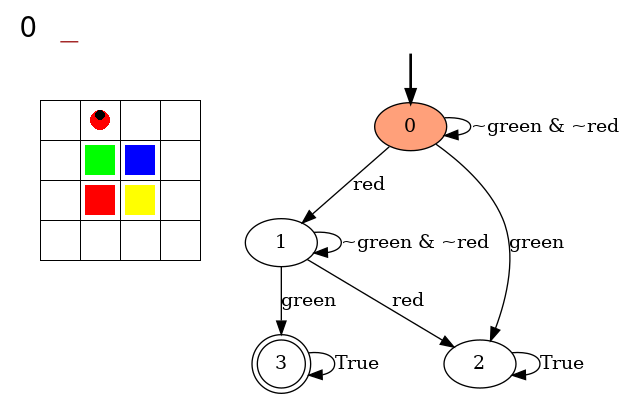

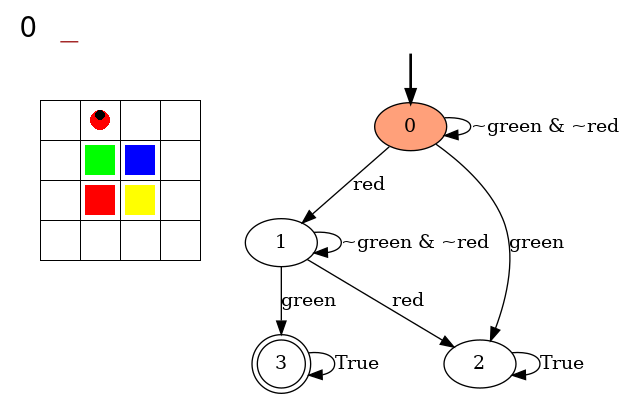

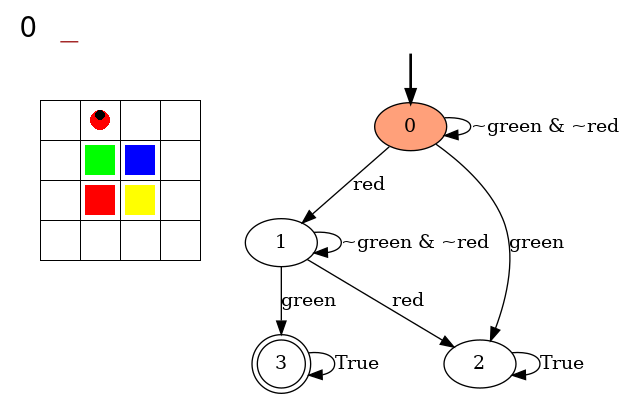

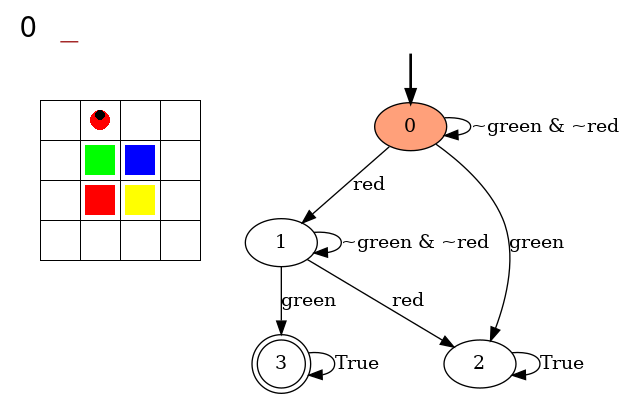

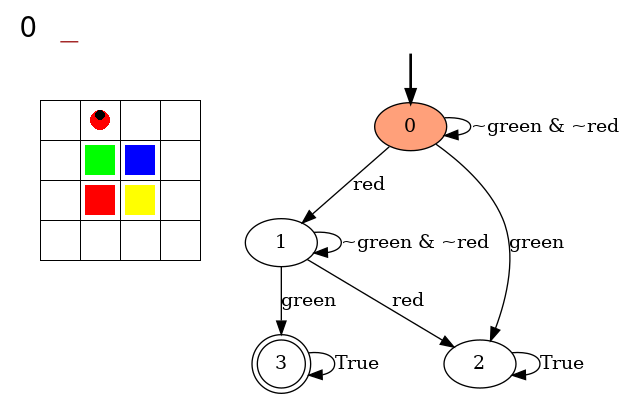

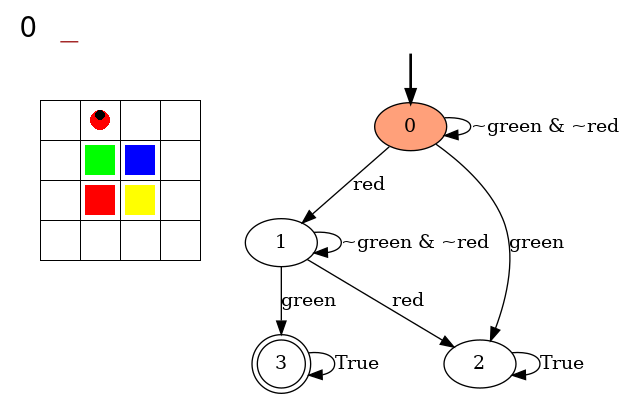

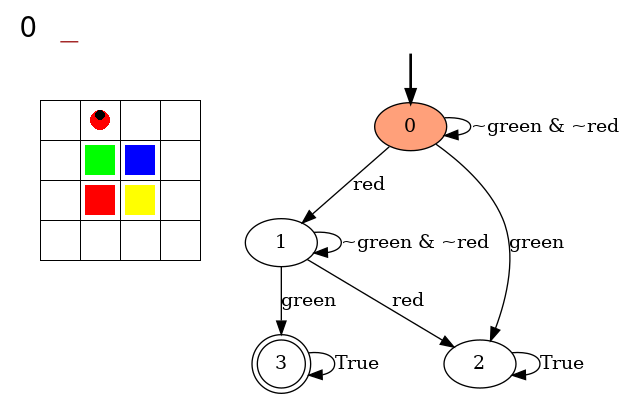

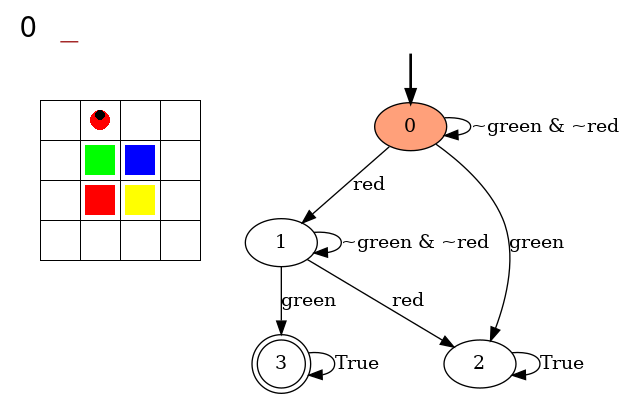

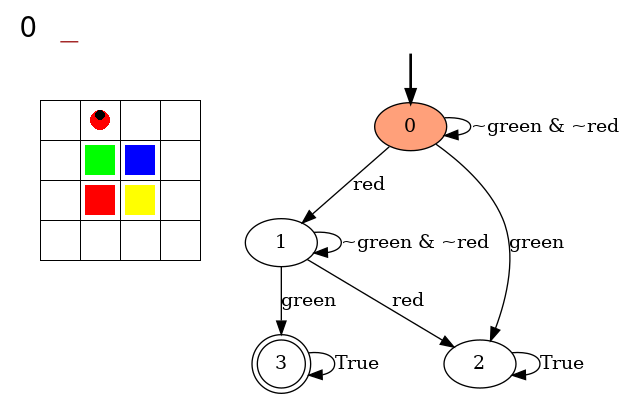

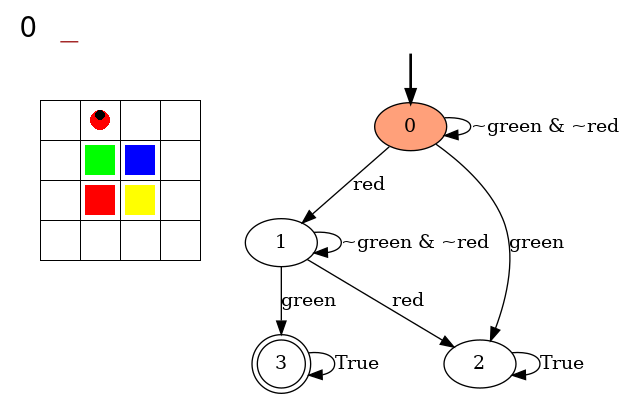

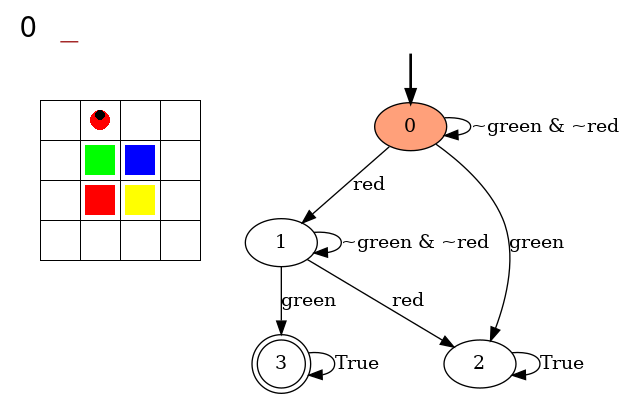

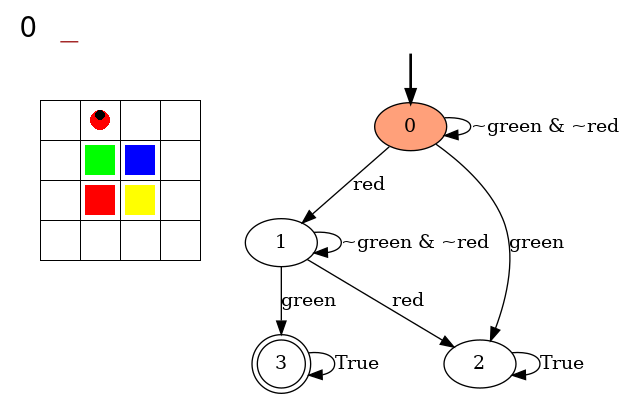

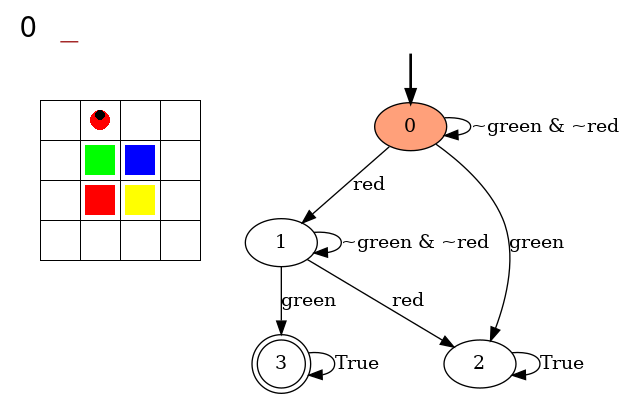

done!
episode rewards: [-0.3000000000000001, -0.3000000000000001, -0.3000000000000001]
episode lengths: [30, 30, 30]
mean reward: -0.3000000000000001


In [22]:
test_env = MyStatsRecorder(TimeLimit(env, max_episode_steps=10))
rollout(test_env, nb_episodes=1, policy=lambda env, state: model.predict(state)[0], callback=print_env)
test_env.close()


print("done!")
print(f"episode rewards: {test_env.episode_rewards}")
print(f"episode lengths: {test_env.episode_lengths}")
print('mean reward:', np.mean(test_env.episode_rewards))
